In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re

import geopandas
from shapely.geometry import Point
import missingno as msn

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/tweets_by_state.csv")
df = df.drop(columns=['hashtags', 'urls'])
df.head()

,Unnamed: 0,Unnamed: 0.1,created_at,text,lang,retweeted,retweet_count,user_mentions,full_location,country,state
0,0,1,Fri Aug 12 10:04:02 +0000 2016,@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,en,False,0,"[{'screen_name': 'BarackObama', 'name': 'Barac...","Baton Rouge, LA",United States,LA
1,1,4,Fri Aug 12 10:04:30 +0000 2016,#CNN #newday clear #Trump deliberately throwin...,en,False,0,[],"Baltimore, MD",United States,MD
2,2,5,Fri Aug 12 10:04:46 +0000 2016,"@realDonaldTrump, you wouldn't recognize a lie...",en,False,0,"[{'screen_name': 'realDonaldTrump', 'name': 'D...","Palm Springs, CA",United States,CA
3,3,7,Fri Aug 12 10:04:48 +0000 2016,"""Kid, you know, suing someone? Thats the most ...",en,False,0,"[{'screen_name': 'funnyordie', 'name': 'Funny ...","Secaucus, NJ",United States,NJ
4,4,8,Fri Aug 12 10:04:48 +0000 2016,@HillaryClinton you ARE the co-founder of ISIS...,en,False,0,"[{'screen_name': 'HillaryClinton', 'name': 'Hi...","Irving, TX",United States,TX


Notebook containing code to do this exploratory data analysis.

https://github.com/enoreese/topic-modelling/blob/master/preprocess.ipynb

In [3]:
def find_hashtags(tweet):
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

df['mentioned'] = df.text.apply(find_mentioned)
df['hashtags'] = df.text.apply(find_hashtags)

# Hashtag analysis

In [4]:
hashtags_list_df = df.loc[df.hashtags.apply(lambda hashtags_list: hashtags_list !=[]),['hashtags']]
flattened_hashtags_df = pd.DataFrame([hashtag for hashtags_list in hashtags_list_df.hashtags for hashtag in hashtags_list], columns=['hashtag'])

In [5]:
flattened_hashtags_df.head()

,hashtag
0,#NOJUSTICE
1,#TrumpPence
2,#CNN
3,#newday
4,#Trump


In [6]:
flattened_hashtags_df = pd.DataFrame(flattened_hashtags_df['hashtag'].str.lower(), columns=["hashtag"])
flattened_hashtags_df['hashtag'].unique().size

31796

In [7]:
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
popular_hashtags.head(10)

,hashtag,counts
0,#trump,30956
1,#nevertrump,13813
2,#imwithher,12010
3,#maga,11043
4,#neverhillary,8293
5,#hillary,8108
6,#crookedhillary,7010
7,#trumppence16,6993
8,#hillaryclinton,5456
9,#donaldtrump,5338


In [8]:
# take hashtags which appear at least this amount of times
min_appearance = 1000
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[popular_hashtags.counts>=min_appearance]['hashtag'])

In [9]:
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]

In [10]:
# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))

In [11]:
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)

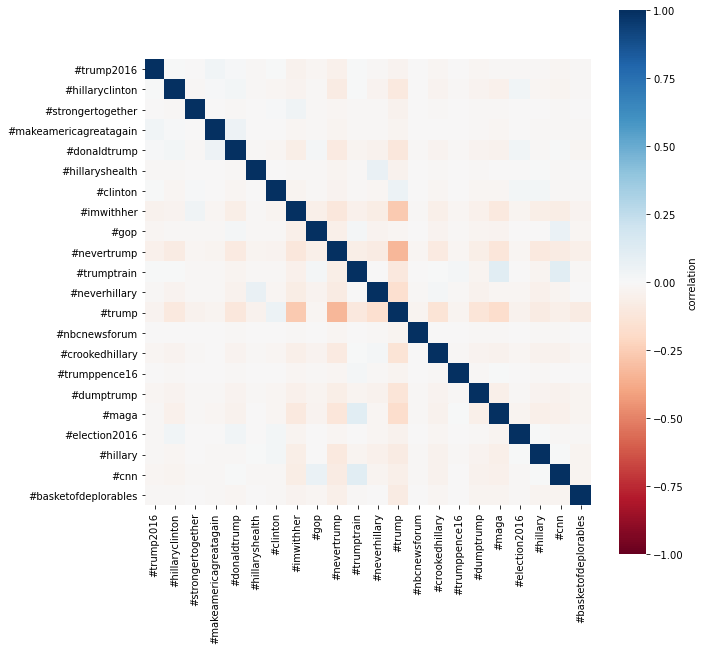

In [12]:
# calculate the correlation matrix
correlations = hashtag_matrix.corr()

# plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.show()

The tweets #maga (makeamericagreatagain) and #imwithillary were the campaign slogan from both election candidates. If these are used as a hashtag that would imply a favor towards one of the candidates. Together with #nevertrump or #neverhillary. That's what is analyzed in the codeblocks below.

In [13]:
#find specific hashtags that contain #maga/#neverhillary
def find_trump_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#((?i)maga|neverhillary(?:$|\W)))', tweet)

df['trump'] = df.text.apply(find_trump_hashtags)

df['trump'] = df['trump'].apply(lambda x: True if x != [] else False)
trump_positive_df = df[df['trump'] == True]

trump_states = trump_positive_df.state.value_counts(normalize=True)
trump_df = pd.DataFrame({'abbreviation':trump_states.index, 'count':trump_states.values})
trump_df = trump_df.sort_values('abbreviation', ascending=True)

<ipython-input-13-ef4434901cb6>:4: DeprecationWarning: Flags not at the start of the expression '(#((?i)maga|neverhil' (truncated)
  return re.findall('(#((?i)maga|neverhillary(?:$|\W)))', tweet)


In [14]:
states = pd.read_csv("data/states.csv")
states = states.sort_values("Code", ascending=True)

country = geopandas.read_file("data/gz_2010_us_040_00_5m.json")
country['abbreviation'] = states['Code']

states['extra'] = country['abbreviation']
states['trump'] = trump_df['abbreviation']

country = country.drop([51], axis=0)

world = pd.merge(country, trump_df, on="abbreviation")

In [15]:
#find specific hashtags that contain #imwithillary/#nevertrump
def find_clinton_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#((?i)imwithher|nevertrump(?:$|\W)))', tweet)

df['clinton'] = df.text.apply(find_clinton_hashtags)

df['clinton'] = df['clinton'].apply(lambda x: True if x != [] else False)
clinton_positive_df = df[df['clinton'] == True]

clinton_states = clinton_positive_df.state.value_counts(normalize=True)
clinton_df = pd.DataFrame({'abbreviation':clinton_states.index, 'count':clinton_states.values})
clinton_df = clinton_df.sort_values('abbreviation', ascending=True)

states['extra'] = country['abbreviation']
states['trump'] = clinton_df['abbreviation']

world_2 = pd.merge(country, clinton_df, on="abbreviation")

<ipython-input-15-b93e1d76e949>:4: DeprecationWarning: Flags not at the start of the expression '(#((?i)imwithher|nev' (truncated)
  return re.findall('(#((?i)imwithher|nevertrump(?:$|\W)))', tweet)


In [16]:
# uncomment if you want separate window for the plots
# %matplotlib qt

<AxesSubplot:title={'center':'Hashtags in favour of Trump'}>

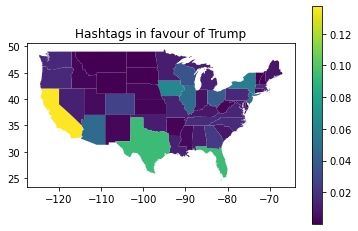

In [17]:
fig, ax = plt.subplots(1, 1)
plt.title("Hashtags in favour of Trump")
world[world['NAME'].isin(['Alaska','Hawaii', 'Puerto Rico']) == False].plot(column='count', ax=ax, legend=True)

<AxesSubplot:title={'center':'Hashtags in favour of Clinton'}>

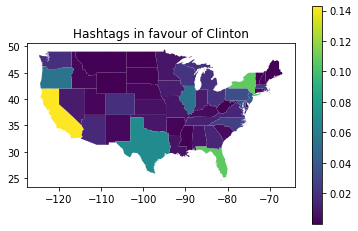

In [18]:
fig, ax = plt.subplots(1, 1)
plt.title("Hashtags in favour of Clinton")
world_2[world_2['NAME'].isin(['Alaska','Hawaii', 'Puerto Rico']) == False].plot(column='count', ax=ax, legend=True)